In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path to merged dataset
df = pd.read_csv("data_clean/merged_dataset.csv")

print("✅ Merged dataset loaded.")
print("Shape:", df.shape)
df.head()

✅ Merged dataset loaded.
Shape: (148, 9)


,Country Code,CountryName,GHG,MF,hale_birth,hale_60,Under5,PPP,World Bank's income classification
0,AFG,Afghanistan,0.795637,1.2455,50.45,9.88,55.5,2210.0,Low-income countries
1,AGO,Angola,1.876773,2.9376,53.76,11.86,64.0,7280.0,Lower-middle-income countries
2,ALB,Albania,2.417479,10.0369,66.69,15.34,9.4,20990.0,Upper-middle-income countries
3,ARE,United Arab Emirates,25.618114,39.7661,67.27,15.10,5.0,76680.0,High-income countries
4,ARG,Argentina,7.948544,16.3294,64.79,14.99,9.6,29460.0,Upper-middle-income countries


## 1.Feature Engineering and Variable Transformation

In [3]:
# Unify Column Names
if 'Country Name_x' in df.columns:
    df.drop(columns=['Country Name_x'], inplace=True, errors='ignore')
if 'Country Name_y' in df.columns:
    df.rename(columns={'Country Name_y': 'CountryName'}, inplace=True)
if 'Country' in df.columns and 'CountryName' not in df.columns:
    df.rename(columns={'Country': 'CountryName'}, inplace=True)

# Convert Key Indicators to Numeric Format
num_cols = ['GHG','MF','HALE','Under5','PPP']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Classify Countries Into Global North and South
PPP_THRESHOLD = 14_000
df['North_South'] = np.where(df['PPP'] >= PPP_THRESHOLD, 'Global North', 'Global South')
df['North_dummy'] = (df['North_South'] == 'Global North').astype(int)

# Log-transform Skewed Variables
for c in ['GHG','MF','PPP','Under5']:
    df[f'log_{c}'] = np.where(df[c] > 0, np.log(df[c]), np.nan)

# Create Interaction Term for Global North Effect on MF
df['interaction'] = df['log_MF'] * df['North_dummy']

# Finalize the Cleaned Analytical Dataset
use = df[['Country Code','CountryName','North_South','GHG','MF','HALE','Under5','PPP',
          'log_GHG','log_MF','log_PPP','North_dummy','interaction']].dropna().copy()
print("analysis rows:", use.shape[0])
use.head()

KeyError: 'HALE'

# 3.Data Analysis

## 3.1 Relationship Between Material Footprint and Healthy Life Expectancy

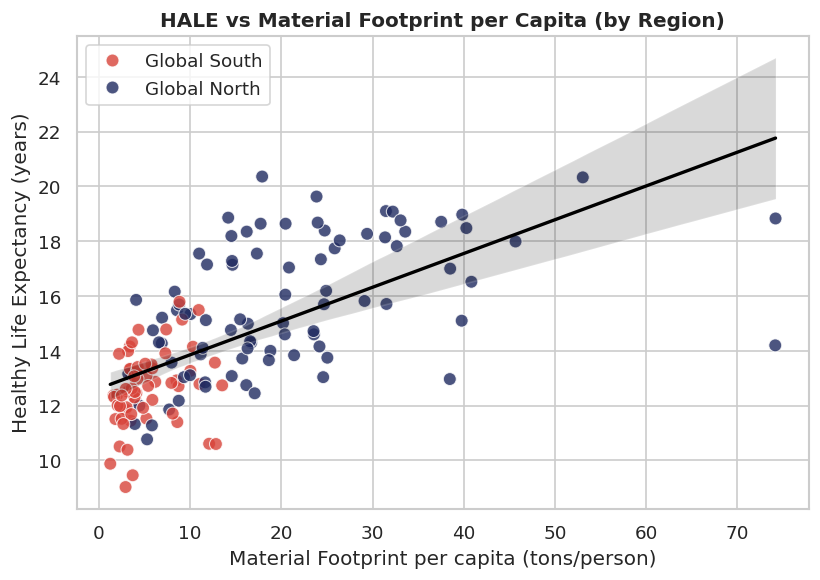

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot HALE vs Material Footprint per Capita (by Region)

sns.set_theme(style="whitegrid")

# Navy for Global North, Red for Global South
palette = {"Global North": "#1F2A60", "Global South": "#D84339"}

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, x="MF", y="HALE", hue="North_South",
    palette=palette, hue_order=["Global South", "Global North"],
    s=60, alpha=0.8, edgecolor="white"
)
sns.regplot(
    data=df, x="MF", y="HALE",
    scatter=False, color="black", line_kws={'lw':2}
)
plt.title("HALE vs Material Footprint per Capita (by Region)", fontsize=12, weight='bold')
plt.xlabel("Material Footprint per capita (tons/person)")
plt.ylabel("Healthy Life Expectancy (years)")
plt.legend(title="")
plt.tight_layout()
plt.show()

## 3.2 Relationship Between Material Footprint and Greenhouse Gas Emissions

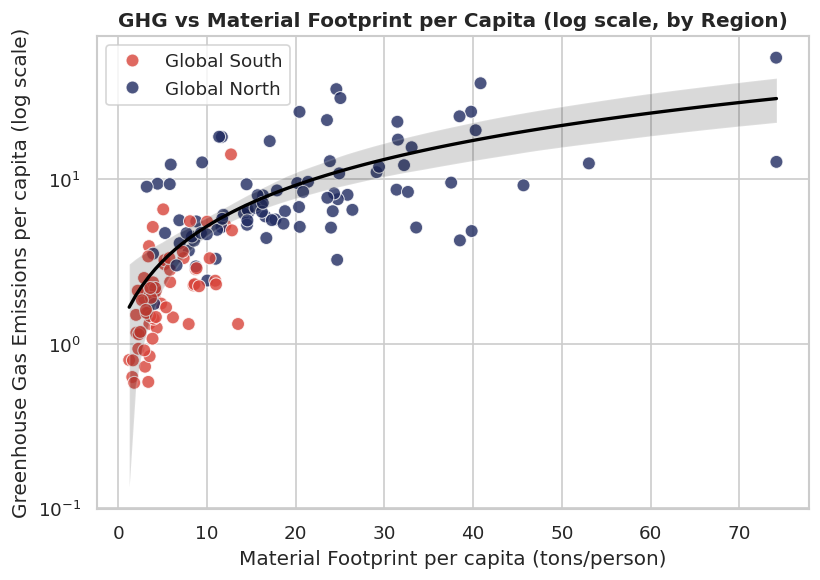

In [ ]:
# Plot GHG vs Material Footprint per Capita (log scale, by Region)

import seaborn as sns
import matplotlib.pyplot as plt

# Navy for Global North, Red for Global South
palette = {"Global North": "#1F2A60", "Global South": "#D84339"}

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, x="MF", y="GHG", hue="North_South",
    palette=palette, hue_order=["Global South", "Global North"],
    s=60, alpha=0.8, edgecolor="white"
)
sns.regplot(
    data=df, x="MF", y="GHG",
    scatter=False, color="black", line_kws={'lw':2}
)
plt.yscale("log")
plt.title("GHG vs Material Footprint per Capita (log scale, by Region)", fontsize=12, weight='bold')
plt.xlabel("Material Footprint per capita (tons/person)")
plt.ylabel("Greenhouse Gas Emissions per capita (log scale)")
plt.legend(title="")
plt.tight_layout()
plt.show()

## 3.3 Elasticity Between Emissions and Material Use (log–log)

This plot shows the log–log relationship between Material Footprint and GHG emissions per capita, capturing elasticity; how sensitive emissions are to changes in material use.
The regression lines illustrate that Global North countries generally produce higher emissions per unit of material consumption, while Global South countries exhibit lower elasticity.

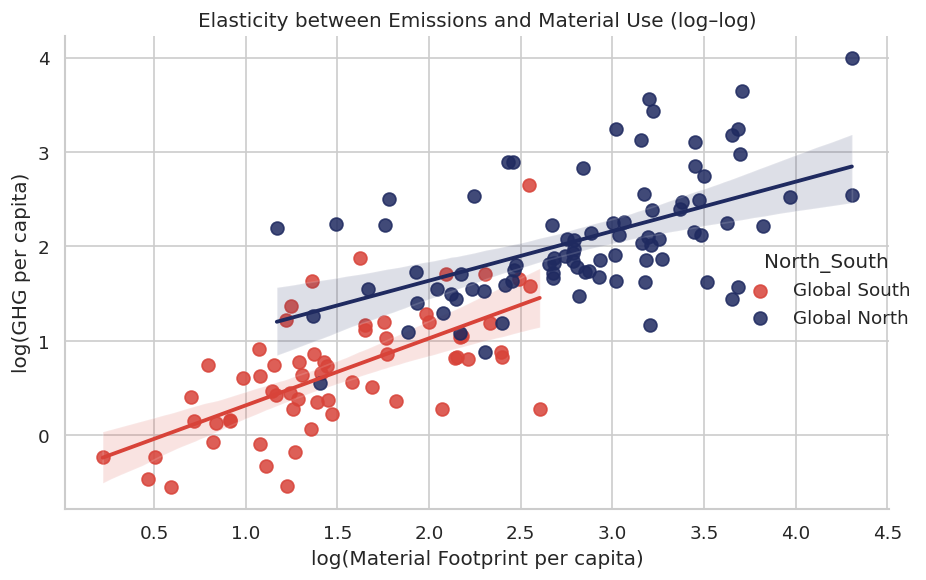

In [ ]:
## 3.3 Elasticity Between Emissions and Material Use (log–log)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Navy for Global North, Red for Global South
palette = {"Global North": "#1F2A60", "Global South": "#D84339"}

sns.lmplot(
    data=df, x="log_MF", y="log_GHG", hue="North_South",
    palette={"Global North": "#1F2A60", "Global South": "#D84339"},
    height=5, aspect=1.25,
    scatter_kws={"alpha":0.85, "s":60},
    line_kws={"lw":2.3}
)

plt.title("Elasticity between Emissions and Material Use (log–log)")
plt.xlabel("log(Material Footprint per capita)")
plt.ylabel("log(GHG per capita)")
plt.tight_layout()

# 4.Model Fit

## 4.1 Ordinary Least Squares (OLS) Regression

The OLS model examines how material use and socioeconomic factors affect Healthy Life Expectancy (HALE).
Predictors include log-transformed Material Footprint, Purchasing Power (PPP), Under-5 Mortality, and a North–South interaction term.
The model achieves an R² of ~0.60, suggesting that these variables explain about 60% of the variation in HALE across countries.

In [ ]:
# Fit and Summarize OLS Model

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

hale_formula = 'HALE ~ log_MF + North_dummy + interaction + log_PPP + Under5'
hale_fit = smf.ols(hale_formula, data=use).fit(cov_type='HC3')
print(hale_fit.summary())

# Check Multicollinearity using Variance Inflation Factor (VIF)

Xv = use[['log_MF','log_PPP','Under5','North_dummy','interaction']].copy()
Xv = sm.add_constant(Xv)
vif_tbl = pd.DataFrame({'feature': Xv.columns,
                        'VIF': [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]})
print(vif_tbl.sort_values('VIF', ascending=False))

                            OLS Regression Results                            
Dep. Variable:                   HALE   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     39.50
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.42e-25
Time:                        09:56:59   Log-Likelihood:                -279.97
No. Observations:                 149   AIC:                             571.9
Df Residuals:                     143   BIC:                             590.0
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.9075      2.769      1.411      

## 4.2 Multicollinearity and Variable Significance

This step evaluates potential multicollinearity among predictors and identifies which variables significantly influence Healthy Life Expectancy (HALE). The correlation matrix highlights strong relationships among log-transformed variables (notably between log_MF and log_PPP), indicating possible collinearity. The sorted p-values from the OLS regression show that log_PPP, the North–South interaction, and the regional dummy (North_dummy) are statistically significant at the 1% level, while Under-5 Mortality is marginally significant.

In [ ]:
df.describe()[['GHG','MF','HALE','Under5','PPP']]
df[['log_GHG','log_MF','log_PPP','Under5','North_dummy']].corr().round(2)



,log_GHG,log_MF,log_PPP,Under5,North_dummy
log_GHG,1.000,0.800,0.830,-0.630,0.730
log_MF,0.800,1.000,0.900,-0.710,0.730
log_PPP,0.830,0.900,1.000,-0.820,0.840
Under5,-0.630,-0.710,-0.820,1.000,-0.710
North_dummy,0.730,0.730,0.840,-0.710,1.000


In [ ]:
sig_table = hale_ols.pvalues.sort_values()
sig_table

,0
log_PPP,0.000
interaction,0.001
North_dummy,0.002
Under5,0.085
Intercept,0.158
log_MF,0.196


## 4.3 Residual Diagnostics and Model Assumptions


To validate the regression assumptions, the residuals’ behavior are examined:

1.   Histogram (Residual distribution): confirms approximate normality
2.   QQ plot: points align near the 45° line, indicating limited deviation from normality.
3. Residuals vs Fitted values: the spread is random around zero, suggesting homoscedasticity (constant variance).

These diagnostics collectively support the robustness of the OLS model, though a slight right-tail skew may indicate mild heteroscedasticity. This is addressed in the following section through robust standard errors and Ridge regularization.

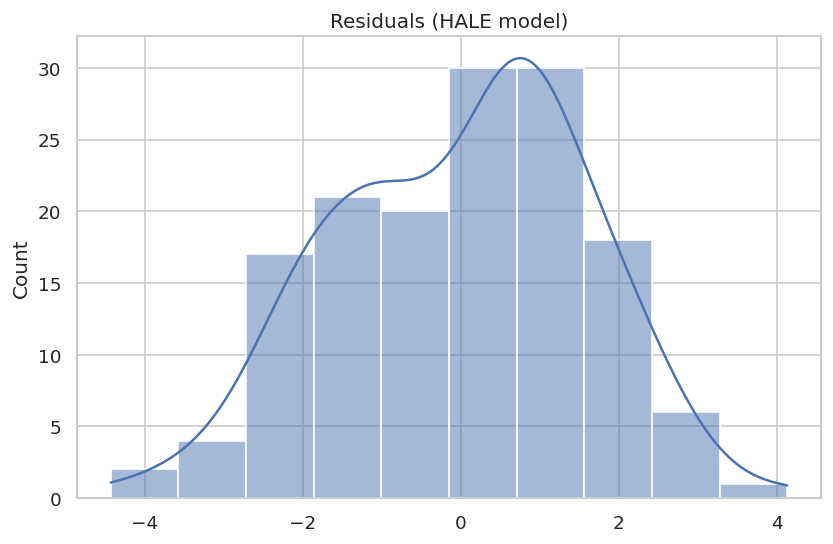

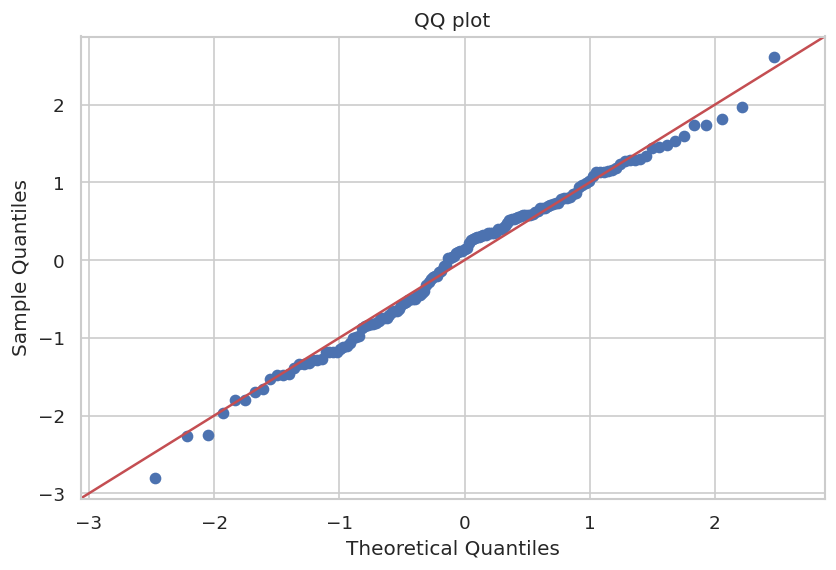

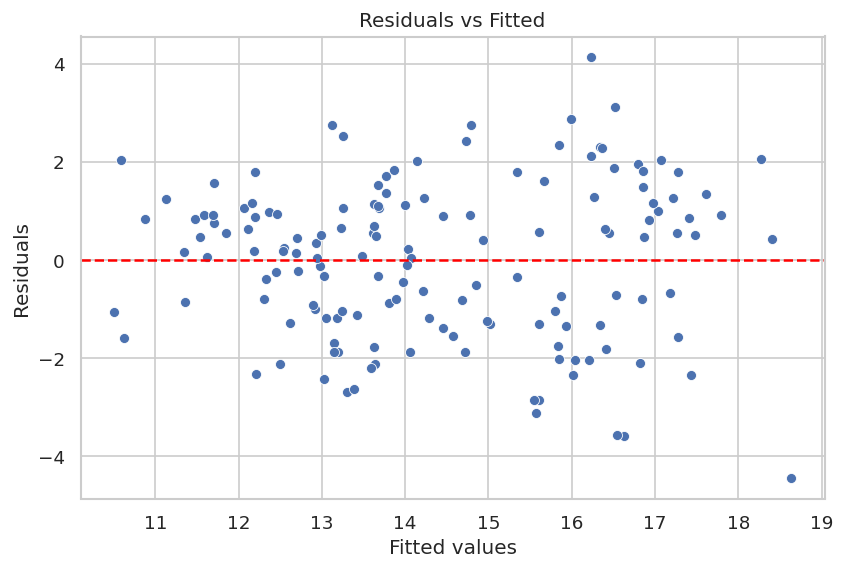

In [ ]:
resid = hale_fit.resid

# Residual Distribution
sns.histplot(resid, kde=True)
plt.title('Residuals (HALE model)')
plt.show()

# Normality Check (QQ plot)
sm.qqplot(resid, line='45', fit=True)
plt.title('QQ plot')
plt.show()

# Homoscedasticity Check (Residuals vs Fitted)
sns.scatterplot(x=hale_fit.fittedvalues, y=resid)
plt.axhline(0, ls='--', c='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()


## 4.4 Robustness and Ridge Regression

After detecting heteroscedasticity through the Breusch–Pagan test, the model is re-estimated using Ridge regression with standardization and log transformation to address both multicollinearity and variance instability. Ridge regularization helps stabilize coefficient estimates by shrinking them toward zero, improving reliability while maintaining interpretability.

### 4.4.1 Model Robustness Checks: Autocorrelation & Heteroscedasticity

In [ ]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Durbin–Watson test (autocorrelation)
dw = durbin_watson(hale_fit.resid)
print(f"Durbin–Watson statistic: {dw:.3f}")
if 1.5 < dw < 2.5:
    print("No autocorrelation detected.")
else:
    print("Possible autocorrelation detected.")

# Breusch–Pagan test (heteroscedasticity)
bp_test = het_breuschpagan(hale_fit.resid, hale_fit.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(bp_labels, bp_test))
print("\nBreusch–Pagan test results:")
for k, v in bp_results.items():
    print(f"{k}: {v:.4f}")

if bp_results['p-value'] > 0.05:
    print("Homoscedasticity assumed (no heteroscedasticity).")
else:
    print("Heteroscedasticity detected — consider robust SE or Ridge correction.")

Durbin–Watson statistic: 1.762
No autocorrelation detected.

Breusch–Pagan test results:
Lagrange multiplier statistic: 17.1927
p-value: 0.0041
f-value: 3.7305
f p-value: 0.0033
Heteroscedasticity detected — consider robust SE or Ridge correction.


The Durbin–Watson test indicates no autocorrelation (DW = 1.76).
However, the Breusch–Pagan test yields a p-value below 0.05, confirming heteroscedasticity, which justifies applying robust standard errors or a regularized approach (Ridge).

### 4.4.2 Ridge Regression with Standardization and Log Transformation

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np, pandas as pd

X = df[['log_MF','log_PPP','Under5','North_dummy','interaction']].dropna()
y = df.loc[X.index, 'HALE']

ridge_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3,3,50)))
])
ridge_pipe.fit(X, y)
ridge = ridge_pipe.named_steps['ridge']

print("Best alpha:", ridge.alpha_)
print("R²:", ridge_pipe.score(X, y))

coef = pd.Series(ridge.coef_, index=X.columns)
coef

Best alpha: 0.49417133613238334
R²: 0.6006067345798067


,0
log_MF,-0.346
log_PPP,1.348
Under5,-0.359
North_dummy,-1.514
interaction,2.022


The model is re-estimated using RidgeCV with cross-validation and standardized predictors.
Optimal shrinkage (α) is automatically selected.
The resulting R² ≈ 0.60, similar to the OLS model, but Ridge provides more stable coefficients by penalizing over-influential variables.

### 4.4.3 Standardized Ridge Coefficients Visualization

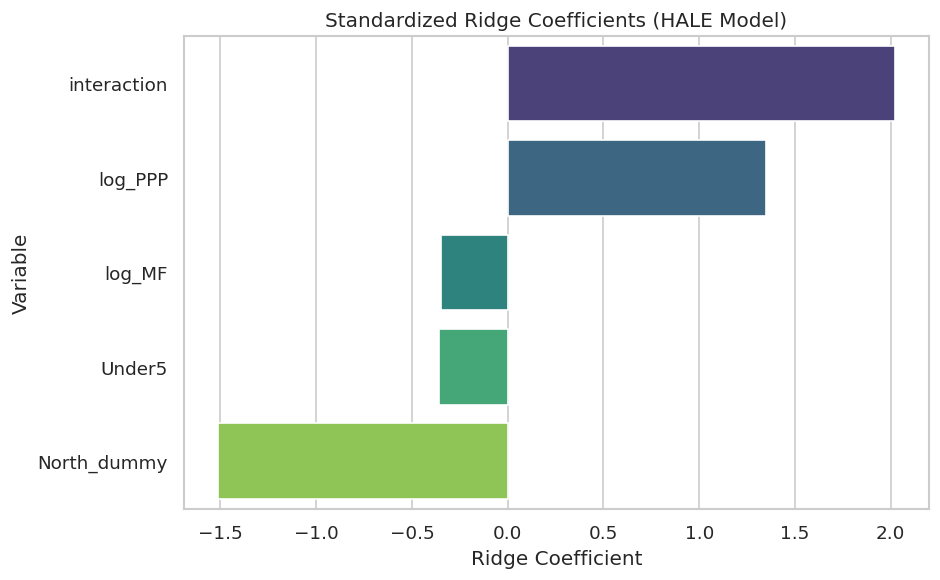

In [ ]:
coef_df = pd.DataFrame({
    "Variable": list(coef.index),
    "Ridge Coefficient": coef.values
}).sort_values("Ridge Coefficient", ascending=False)

sns.barplot(data=coef_df, x="Ridge Coefficient", y="Variable", palette="viridis")
plt.title("Standardized Ridge Coefficients (HALE Model)")
plt.tight_layout()
plt.show()

The interaction term has the strongest positive influence on HALE, followed by economic capacity (log_PPP).
Negative coefficients for North_dummy, log_MF, and Under5 imply that higher material intensity and mortality correlate with lower life expectancy.
This confirms that structural inequality (captured by North–South interaction) remains a dominant driver of health outcomes.

### 4.4.4 VIF after Ridge Standardization

Variance Inflation Factor (VIF) values are recalculated after standardization.
Results show reduced multicollinearity compared to the OLS model, though the interaction and regional dummy remain relatively correlated, it is consistent with their conceptual overlap. Overall, the Ridge model provides a more reliable and interpretable fit under multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
X_std = StandardScaler().fit_transform(X)
X_std = sm.add_constant(X_std)
vif = pd.DataFrame({
    "Feature": ['const'] + list(X.columns),
    "VIF": [variance_inflation_factor(X_std, i) for i in range(X_std.shape[1])]
})
vif.sort_values("VIF", ascending=False)

,Feature,VIF
5,interaction,25.880
4,North_dummy,15.783
2,log_PPP,10.859
1,log_MF,10.100
3,Under5,3.154
0,const,1.000


# 3.Data Analysis (Unedited)

In [ ]:
### inpute the ppp acccording to global south or north average

ppp_mean = df.groupby('Country Code')['PPP'].mean().reset_index()
ppp_mean.rename(columns={'PPP':'PPP_mean'}, inplace=True)
threshold = 14000
ppp_mean['North_South'] = ppp_mean['PPP_mean'].apply(lambda x: 'Global North' if x >= threshold else 'Global South')
df = df.merge(ppp_mean[['Country Code','North_South']], on='Country Code', how='left')

### 3.1 Description Analysis

North South Counts: North_South
Global North    86
Global South    63
Name: count, dtype: int64


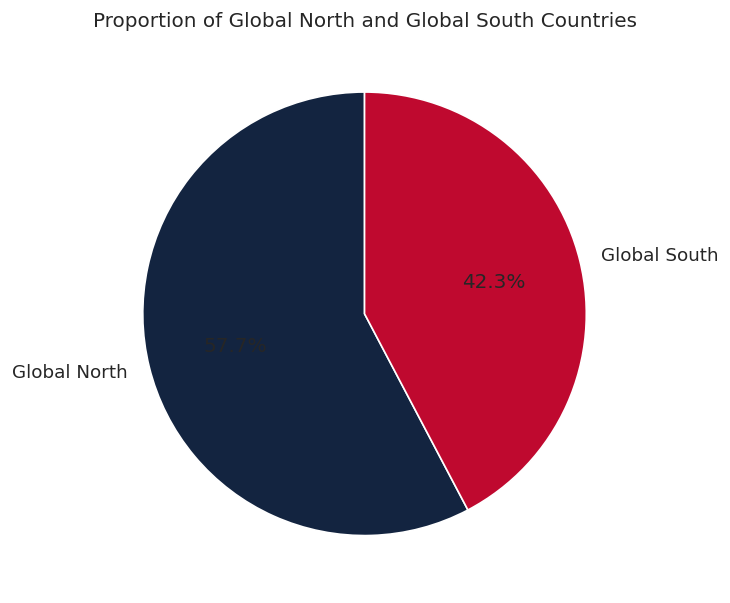

In [ ]:

north_south_counts = ppp_mean['North_South'].value_counts()
print("North South Counts:",north_south_counts)
north_south_ratio = north_south_counts / north_south_counts.sum()

plt.figure(figsize=(6,6))
plt.pie(north_south_counts, labels=north_south_counts.index, autopct='%1.1f%%', startangle=90, colors=['#132440','#BF092F'])
plt.title('Proportion of Global North and Global South Countries')
plt.show()



In [ ]:
south_mean_ppp = df.loc[df['North_South'] == 'Global South', 'PPP'].mean()
print("Global South average PPP:", south_mean_ppp)
df['PPP'] = df['PPP'].fillna(south_mean_ppp)
print("Remaining missing PPP:", df['PPP'].isna().sum())



KeyError: 'North_South'

/tmp/ipython-input-3380814485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='North_South', y='PPP', data=df, palette=['#132440','#BF092F'])


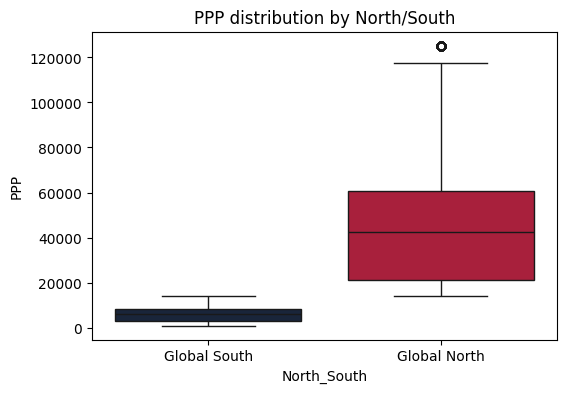

/tmp/ipython-input-3380814485.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='North_South', y='GHG', data=df, palette=['#132440','#BF092F'])


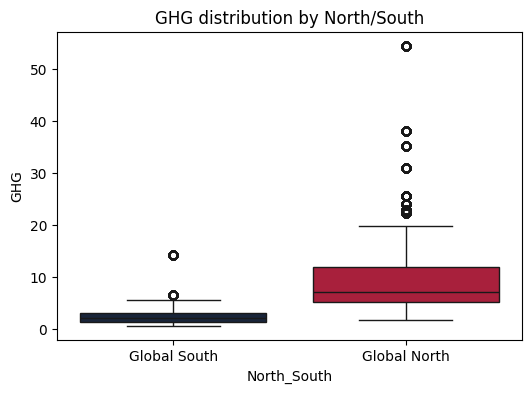

/tmp/ipython-input-3380814485.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='North_South', y='HALE', data=df, palette=['#132440','#BF092F'])


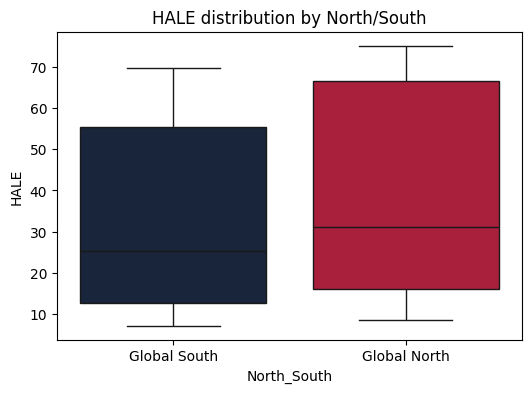

In [ ]:

plt.figure(figsize=(6,4))
sns.boxplot(x='North_South', y='PPP', data=df, palette=['#132440','#BF092F'])
plt.title('PPP distribution by North/South')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='North_South', y='GHG', data=df, palette=['#132440','#BF092F'])
plt.title('GHG distribution by North/South')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='North_South', y='HALE', data=df, palette=['#132440','#BF092F'])
plt.title('HALE distribution by North/South')
plt.show()


### 3.2 Correlation Analysis

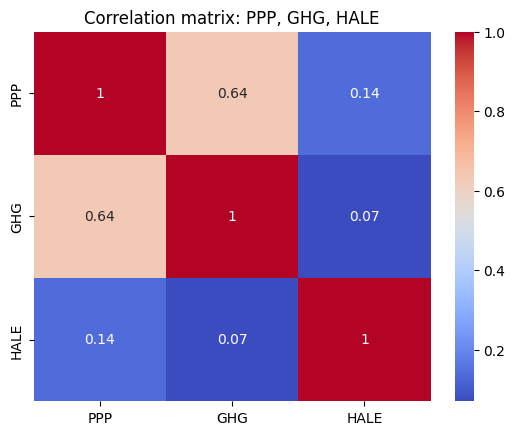

PPP       GHG      HALE
North_South                                    
Global North PPP   1.000000  0.458447  0.064979
             GHG   0.458447  1.000000 -0.006313
             HALE  0.064979 -0.006313  1.000000
Global South PPP   1.000000  0.570800  0.118604
             GHG   0.570800  1.000000  0.063012
             HALE  0.118604  0.063012  1.000000

In [ ]:
corr = df[['PPP','GHG','HALE']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix: PPP, GHG, HALE')
plt.show()
df.groupby('North_South')[['PPP','GHG','HALE']].corr()


### 3.3 Which correlation need our attention

#### 3.3.1 Total
- PPP - GHG = 0.64

#### Global North 💰
- PPP - GHG = 0.46

#### Global South 😭
- PPP - GHG = 0.57

### 3.4 T-test of main variables

In [ ]:


# PPP
ttest_ind(df[df['North_South']=='Global North']['PPP'],
          df[df['North_South']=='Global South']['PPP'])

# GHG
ttest_ind(df[df['North_South']=='Global North']['GHG'],
          df[df['North_South']=='Global South']['GHG'])

# HALE
ttest_ind(df[df['North_South']=='Global North']['HALE'],
          df[df['North_South']=='Global South']['HALE'])
def print_ttest(var):
    north = df[df['North_South']=='Global North'][var].dropna()
    south = df[df['North_South']=='Global South'][var].dropna()
    t_stat, p_val = ttest_ind(north, south, equal_var=False)
    print(f"{var}:\n  t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}\n")

# T-test on PPP, GHG, HALE
for col in ['PPP', 'GHG', 'HALE']:
    print_ttest(col)

PPP:
  t-statistic = 157.359, p-value = 0.00000

GHG:
  t-statistic = 91.840, p-value = 0.00000

HALE:
  t-statistic = 19.733, p-value = 0.00000

